# Leémos las curvas Swap

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re|
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 2 años en adelante hay que aplicar bootstraping (HAY QUE PASAR A TASA 0 CUPÓN)
# Hacer matriz de diferencias (Delta X = X_i - X_i-1)
# Graficar 1M VS TPM (BUSCAR EXCEL EN EL BANCO CENTRAL)

In [2]:
df = pd.read_excel("swap_camara_df.xlsx", sheet_name=0)
df = df.drop(df.index[0])
df = df.dropna().reset_index(drop=True)
df = df.rename(columns={"Unnamed: 0": "Fecha"})
df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce", dayfirst=True)
FECHAS = df.copy() ## Dataframe con las fechas
DFFF = df.copy()   ## Otra cosa

In [3]:
Tenor = {"1M"  : "CHSWPA ICCH Curncy" , "2M" : "CHSWPB ICCH Curncy" , 
         "3M"  : "CHSWPC ICCH Curncy" , "6M" : "CHSWPF ICCH Curncy" , 
         "9M"  : "CHSWPI ICCH Curncy" , "1Y" : "CHSWP1 ICCH Curncy" ,
         "1Y6M": "CHSWP1F ICCH Curncy", "2Y" : "CHSWP2 ICCH Curncy" ,
         "3Y"  : "CHSWP3 ICCH Curncy" , "4Y" : "CHSWP4 ICCH Curncy" ,
         "5Y"  : "CHSWP5 ICCH Curncy" , "7Y" : "CHSWP7 ICCH Curncy" , 
         "10Y" : "CHSWP10 ICCH Curncy", "12Y": "CHSWP12 ICCH Curncy", 
         "15Y" : "CHSWP15 ICCH Curncy", "20Y": "CHSWP20 ICCH Curncy", 
         "25Y" : "CHSWP25 ICCH Curncy"}

In [4]:
ss = StandardScaler(with_std = False)
X = df.copy()
X_cols = df.columns.tolist()[1:]
X[X_cols] = ss.fit_transform(df[X_cols])
n = 2
pca_raw = PCA(n_components = n, random_state = 42)
scores = pca_raw.fit_transform(X[X_cols])

# sns.barplot(x=[f"PCA{i+1}" for i in range(n)], y=pca_raw.explained_variance_ratio_)

# Leémos los registros de la TPM

In [5]:
TPM21 = pd.read_excel("tpm_2021.xls",engine="xlrd")
TPM22 = pd.read_excel("tpm_2022.xls",engine="xlrd")
TPM23 = pd.read_excel("tpm_2023.xls",engine="xlrd")
TPM24 = pd.read_excel("tpm_2024.xls",engine="xlrd")
TPM25 = pd.read_excel("tpm_2025.xls",engine="xlrd")

TPM_raw = pd.concat([TPM21, TPM22, TPM23, TPM24, TPM25], ignore_index=True)
TPM_raw = TPM_raw.dropna().reset_index(drop=True)
TPM_raw = TPM_raw.rename(columns={"Dia": "Fecha","Valor": "TPM"})
TPM_raw

,Fecha,TPM
0,2021-01-04,0.50
1,2021-01-05,0.50
2,2021-01-06,0.50
3,2021-01-07,0.50
4,2021-01-08,0.50
...,...,...
1174,2025-09-22,4.75
1175,2025-09-23,4.75
1176,2025-09-24,4.75
1177,2025-09-25,4.75


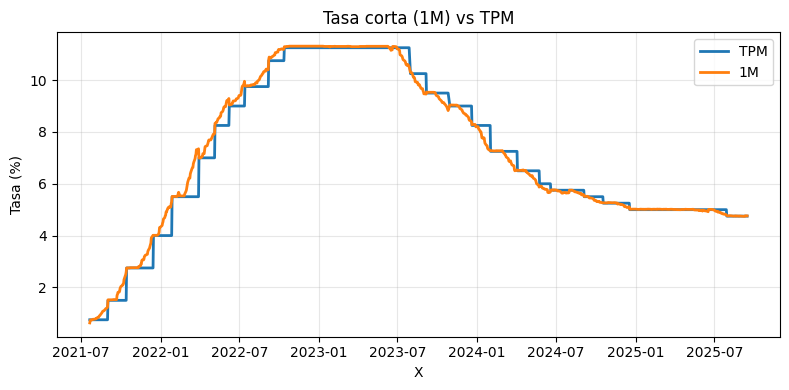

In [6]:
setA = set(TPM_raw["Fecha"])
setB = set(FECHAS["Fecha"])
x = sorted(setA & setB)


plt.figure(figsize=(8,4))
plt.plot(x, TPM_raw[TPM_raw["Fecha"].isin(x)]["TPM"], label="TPM", linewidth=2)
plt.plot(x, FECHAS[FECHAS["Fecha"].isin(x)][Tenor["1M"]], label="1M", linewidth=2)
plt.xlabel("X"); plt.ylabel("Tasa (%)"); plt.title("Tasa corta (1M) vs TPM")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Definimos DF como el dataframe con las columnas en meses y sin la columna de fechas

In [7]:
DF = df.rename(columns={v: k for k, v in Tenor.items()})
def tenor_a_meses(s: str) -> int:
    """
    Convierte un tenor como '1M', '2M', '1Y', '1Y6M', '12Y', ' 1Y 6M ' a meses (int).
    - Y = años, M = meses
    """
    if s is None:
        raise ValueError("Tenor vacío")
    st = str(s).strip().upper().replace(" ", "")
    # Coincide opcionalmente años y/o meses (en ese orden típico)
    m = re.fullmatch(r'(?:(\d+)Y)?(?:(\d+)M)?', st)
    if not m:
        raise ValueError(f"Tenor no reconocido: {s!r}")
    years = int(m.group(1) or 0)
    months = int(m.group(2) or 0)
    return years * 12 + months
DF = DF.rename(columns={v: tenor_a_meses(v) for v in Tenor.keys()})
DF = DF.drop(columns=["Fecha"])
DF

,1,2,3,6,9,12,18,24,36,48,60,84,120,144,180,240,300
0,0.63,0.735,0.89,1.205,1.46,1.71,2.075,2.34,2.685,2.985,3.255,3.72,4.05,4.24,4.365,4.55,4.65
1,0.72,0.82,0.915,1.21,1.465,1.72,2.08,2.33,2.67,2.95,3.215,3.675,4.015,4.2,4.32,4.49,4.59
2,0.745,0.82,0.915,1.21,1.46,1.715,2.07,2.315,2.65,2.93,3.195,3.65,4.005,4.185,4.32,4.485,4.585
3,0.745,0.83,0.935,1.245,1.495,1.745,2.115,2.355,2.69,2.98,3.245,3.7,4.05,4.215,4.335,4.5,4.6
4,0.755,0.85,0.98,1.31,1.575,1.82,2.205,2.475,2.83,3.13,3.39,3.855,4.22,4.39,4.5,4.675,4.775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,4.74,4.725,4.695,4.625,4.575,4.55,4.535,4.44,4.535,4.63,4.73,4.925,5.175,5.29,5.4,5.45,5.45
1038,4.76,4.76,4.745,4.695,4.645,4.62,4.605,4.5,4.58,4.655,4.745,4.935,5.185,5.3,5.41,5.46,5.465
1039,4.76,4.755,4.75,4.685,4.635,4.6,4.585,4.475,4.555,4.63,4.715,4.9,5.145,5.255,5.365,5.42,5.425
1040,4.765,4.765,4.78,4.71,4.68,4.65,4.63,4.52,4.595,4.67,4.765,4.95,5.185,5.295,5.405,5.46,5.46


## DF_nuevo es el dataframe con todos tenores entremedio inexistentes.

In [8]:
# columnas objetivo
months = [1, 2, 3, 6, 9, 12] + list(range(18, 301, 6))
cols = months

# 1) DataFrame vacío con esos nombres de columna
DF_nuevo = pd.DataFrame(columns=cols)
# DF_nuevo["Fecha"] = pd.to_datetime(DF_nuevo["Fecha"])  # dtype datetime


# 2) Si quieres n filas (inicializadas en NaN) y Fecha vacía (NaT):
n = 0  # pon el número de filas deseado
DF_nuevo = pd.DataFrame(index=range(n), columns=cols)
# DF_nuevo["Fecha"] = pd.to_datetime(DF_nuevo["Fecha"])

# 3) Si ya tienes una lista/Serie de fechas para la columna Fecha:
# fechas = pd.date_range("2021-01-01", periods=10, freq="D")
# DF_nuevo = pd.DataFrame({"Fecha": pd.to_datetime(fechas)})
# for c in months: DF_nuevo[c] = pd.NA

for col in DF_nuevo.columns:
    if col in DF.columns:
        DF_nuevo[col] = DF[col]
DF_nuevo = DF_nuevo.fillna(-1)
DF_nuevo


/var/folders/k6/x0pwglw92_74wdc5stx1kj0m0000gn/T/ipykernel_42051/471019776.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DF_nuevo = DF_nuevo.fillna(-1)


,1,2,3,6,9,12,18,24,30,36,...,246,252,258,264,270,276,282,288,294,300
0,0.630,0.735,0.890,1.205,1.460,1.710,2.075,2.340,-1,2.685,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.650
1,0.720,0.820,0.915,1.210,1.465,1.720,2.080,2.330,-1,2.670,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.590
2,0.745,0.820,0.915,1.210,1.460,1.715,2.070,2.315,-1,2.650,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.585
3,0.745,0.830,0.935,1.245,1.495,1.745,2.115,2.355,-1,2.690,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.600
4,0.755,0.850,0.980,1.310,1.575,1.820,2.205,2.475,-1,2.830,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,4.740,4.725,4.695,4.625,4.575,4.550,4.535,4.440,-1,4.535,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.450
1038,4.760,4.760,4.745,4.695,4.645,4.620,4.605,4.500,-1,4.580,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.465
1039,4.760,4.755,4.750,4.685,4.635,4.600,4.585,4.475,-1,4.555,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.425
1040,4.765,4.765,4.780,4.710,4.680,4.650,4.630,4.520,-1,4.595,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.460


## Interpolamos

In [9]:
x_1 = 0
x_2 = 0

for i in range(24, 301, 6):
    if DF_nuevo[i][0] != -1:
        x_1 = i
    else:
        for j in range(i, 301, 6):
            if DF_nuevo[j][0] != -1:
                x_2 = j
                break
        DF_nuevo[i] = DF_nuevo[x_1] + (i-x_1)*(DF_nuevo[x_2]-DF_nuevo[x_1])/(x_2-x_1)
            
DF_nuevo

,1,2,3,6,9,12,18,24,30,36,...,246,252,258,264,270,276,282,288,294,300
0,0.630,0.735,0.890,1.205,1.460,1.710,2.075,2.340,2.5125,2.685,...,4.5600,4.570,4.5800,4.590,4.6000,4.610,4.6200,4.630,4.6400,4.650
1,0.720,0.820,0.915,1.210,1.465,1.720,2.080,2.330,2.5000,2.670,...,4.5000,4.510,4.5200,4.530,4.5400,4.550,4.5600,4.570,4.5800,4.590
2,0.745,0.820,0.915,1.210,1.460,1.715,2.070,2.315,2.4825,2.650,...,4.4950,4.505,4.5150,4.525,4.5350,4.545,4.5550,4.565,4.5750,4.585
3,0.745,0.830,0.935,1.245,1.495,1.745,2.115,2.355,2.5225,2.690,...,4.5100,4.520,4.5300,4.540,4.5500,4.560,4.5700,4.580,4.5900,4.600
4,0.755,0.850,0.980,1.310,1.575,1.820,2.205,2.475,2.6525,2.830,...,4.6850,4.695,4.7050,4.715,4.7250,4.735,4.7450,4.755,4.7650,4.775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,4.740,4.725,4.695,4.625,4.575,4.550,4.535,4.440,4.4875,4.535,...,5.4500,5.450,5.4500,5.450,5.4500,5.450,5.4500,5.450,5.4500,5.450
1038,4.760,4.760,4.745,4.695,4.645,4.620,4.605,4.500,4.5400,4.580,...,5.4605,5.461,5.4615,5.462,5.4625,5.463,5.4635,5.464,5.4645,5.465
1039,4.760,4.755,4.750,4.685,4.635,4.600,4.585,4.475,4.5150,4.555,...,5.4205,5.421,5.4215,5.422,5.4225,5.423,5.4235,5.424,5.4245,5.425
1040,4.765,4.765,4.780,4.710,4.680,4.650,4.630,4.520,4.5575,4.595,...,5.4600,5.460,5.4600,5.460,5.4600,5.460,5.4600,5.460,5.4600,5.460


## Definimos Rates el dataframe de las tasas en decimal y DFACTOR el factor de descuento

In [10]:
RATES   = DF_nuevo.copy()          
DFACTOR = DF_nuevo.copy() 

# Tramo corto: 1M,2M,3M,6M,9M,12M,18M
short_months = [1, 2, 3, 6, 9, 12, 18]
for m in short_months:
    r = RATES[m] / 100.0          # tasa en decimal
    delta = m/12.0                # si prefieres ACT/360 usa días/360
    DFACTOR[m] = 1.0 / (1.0 + r*delta)

# --- 2) Bootstrap semestral (> 18M) con alpha=0.5 ---
for m in range(24, 301, 6):       # 24,30,36,...,300
    K = RATES[m] / 100.0          # usa la tasa PAR del tenor m desde el DataFrame de tasas
    prev = list(range(6, m, 6))   # 6,12,...,m-6  (OJO: excluye m)
    S = 0.5 * DFACTOR[prev].sum(axis=1, min_count=1)  # suma POR FILA de los DF previos
    DFACTOR[m] = (1.0 - K*S) / (1.0 + K*0.5)

## TASAS_0_CUPON es la tasa luego del bootstrapping

In [11]:
TASAS_0_CUPON = DFACTOR.copy()
for j in DFACTOR.columns.tolist():
    TASAS_0_CUPON[j] = ( 1 / DFACTOR[j] - 1)* 12/j*100
TASAS_0_CUPON

,1,2,3,6,9,12,18,24,30,36,...,246,252,258,264,270,276,282,288,294,300
0,0.630,0.735,0.890,1.205,1.460,1.710,2.075,2.391460,2.589869,2.795301,...,7.999123,8.142310,8.290008,8.442392,8.599648,8.761974,8.929580,9.102689,9.281540,9.466385
1,0.720,0.820,0.915,1.210,1.465,1.720,2.080,2.380756,2.576325,2.778761,...,7.811711,7.950298,8.093200,8.240585,8.392628,8.549519,8.711456,8.878652,9.051332,9.229735
2,0.745,0.820,0.915,1.210,1.460,1.715,2.070,2.365007,2.557638,2.756974,...,7.803436,7.941700,8.084270,8.231314,8.383006,8.539534,8.701097,8.867906,9.040185,9.218175
3,0.745,0.830,0.935,1.245,1.495,1.745,2.115,2.406638,2.599933,2.800038,...,7.825560,7.964773,8.108317,8.256360,8.409080,8.566666,8.729320,8.897254,9.070696,9.249887
4,0.755,0.850,0.980,1.310,1.575,1.820,2.205,2.532350,2.738485,2.952266,...,8.320622,8.473160,8.630560,8.793016,8.960733,9.133930,9.312839,9.497707,9.688799,9.886394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,4.740,4.725,4.695,4.625,4.575,4.550,4.535,4.588261,4.694346,4.803867,...,10.206654,10.364909,10.526484,10.691437,10.859828,11.031720,11.207178,11.386270,11.569066,11.755636
1038,4.760,4.760,4.745,4.695,4.645,4.620,4.605,4.652056,4.751137,4.853244,...,10.236999,10.399064,10.564648,10.733819,10.906650,11.083214,11.263591,11.447859,11.636102,11.828406
1039,4.760,4.755,4.750,4.685,4.635,4.600,4.585,4.625083,4.723574,4.825049,...,10.115882,10.274638,10.436820,10.602493,10.771727,10.944594,11.121168,11.301527,11.485750,11.673920
1040,4.765,4.765,4.780,4.710,4.680,4.650,4.630,4.673275,4.770030,4.869670,...,10.234013,10.393082,10.555492,10.721301,10.890571,11.063364,11.239747,11.419789,11.603558,11.791128


## Filtramos a los 17 tenores originales

In [12]:
TASAS_0_CUPON_FILTRADAS = TASAS_0_CUPON[DF.columns.tolist()]
TASAS_0_CUPON_FILTRADAS 

,1,2,3,6,9,12,18,24,36,48,60,84,120,144,180,240,300
0,0.630,0.735,0.890,1.205,1.460,1.710,2.075,2.391460,2.795301,3.177638,3.555096,4.314135,5.112941,5.711661,6.403304,7.860283,9.466385
1,0.720,0.820,0.915,1.210,1.465,1.720,2.080,2.380756,2.778761,3.137021,3.506458,4.253084,5.060007,5.641446,6.308484,7.677285,9.229735
2,0.745,0.820,0.915,1.210,1.460,1.715,2.070,2.365007,2.756974,3.114402,3.482806,4.219634,5.047786,5.616674,6.319192,7.669325,9.218175
3,0.745,0.830,0.935,1.245,1.495,1.745,2.115,2.406638,2.800038,3.170938,3.541936,4.285301,5.115655,5.660566,6.331965,7.690522,9.249887
4,0.755,0.850,0.980,1.310,1.575,1.820,2.205,2.532350,2.952266,3.341168,3.713810,4.491260,5.384406,5.971542,6.665941,8.172764,9.886394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,4.740,4.725,4.695,4.625,4.575,4.550,4.535,4.588261,4.803867,5.034427,5.288922,5.852851,6.808229,7.464542,8.465189,10.051662,11.755636
1038,4.760,4.760,4.745,4.695,4.645,4.620,4.605,4.652056,4.853244,5.061272,5.304032,5.862824,6.821400,7.480023,8.484541,10.078387,11.828406
1039,4.760,4.755,4.750,4.685,4.635,4.600,4.585,4.625083,4.825049,5.031707,5.266096,5.812707,6.751518,7.388868,8.376089,9.960488,11.673920
1040,4.765,4.765,4.780,4.710,4.680,4.650,4.630,4.673275,4.869670,5.078623,5.329214,5.882981,6.815283,7.461496,8.464087,10.078228,11.791128


## Hacemos PCA a las tasas 0 cupón

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

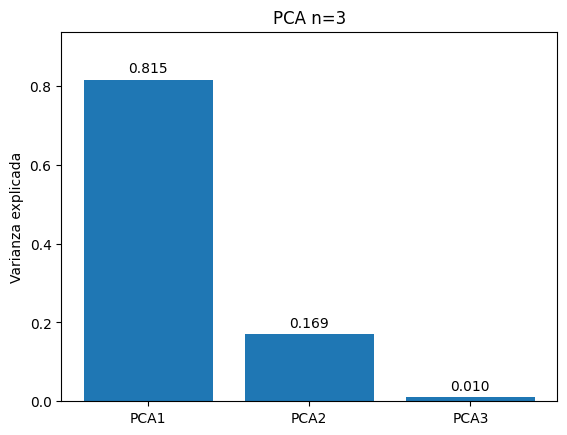

In [13]:
ss = StandardScaler(with_std=False)
X = TASAS_0_CUPON_FILTRADAS.copy()
X_cols = TASAS_0_CUPON_FILTRADAS .columns.tolist()
X[X_cols] = ss.fit_transform(TASAS_0_CUPON_FILTRADAS [X_cols])
n = 3
pca_raw = PCA(n_components = n, random_state = 42)
scores = pca_raw.fit_transform(X[X_cols])

# sns.barplot(x=[f"PCA{i+1}" for i in range(n)], y=pca_raw.explained_variance_ratio_)
labels = ["PCA1", "PCA2", "PCA3"]
vals   = pca_raw.explained_variance_ratio_  # por ejemplo, varianza explicada

fig, ax = plt.subplots()
bars = ax.bar(labels, vals)

ax.set_title("PCA n=3")
# espacio arriba para que quepan los números
ax.set_ylim(0, max(vals)*1.15)

# Opción A: en decimales
ax.bar_label(bars, fmt="%.3f", padding=3)

# Si prefieres en porcentaje, comenta la línea anterior y usa esta:
# ax.bar_label(bars, labels=[f"{v*100:.1f}%" for v in vals], padding=3)

ax.set_ylabel("Varianza explicada")

plt.savefig("PCA.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.tight_layout

In [14]:
DIFMATRIX = TASAS_0_CUPON.copy()
DIFMATRIX

,1,2,3,6,9,12,18,24,30,36,...,246,252,258,264,270,276,282,288,294,300
0,0.630,0.735,0.890,1.205,1.460,1.710,2.075,2.391460,2.589869,2.795301,...,7.999123,8.142310,8.290008,8.442392,8.599648,8.761974,8.929580,9.102689,9.281540,9.466385
1,0.720,0.820,0.915,1.210,1.465,1.720,2.080,2.380756,2.576325,2.778761,...,7.811711,7.950298,8.093200,8.240585,8.392628,8.549519,8.711456,8.878652,9.051332,9.229735
2,0.745,0.820,0.915,1.210,1.460,1.715,2.070,2.365007,2.557638,2.756974,...,7.803436,7.941700,8.084270,8.231314,8.383006,8.539534,8.701097,8.867906,9.040185,9.218175
3,0.745,0.830,0.935,1.245,1.495,1.745,2.115,2.406638,2.599933,2.800038,...,7.825560,7.964773,8.108317,8.256360,8.409080,8.566666,8.729320,8.897254,9.070696,9.249887
4,0.755,0.850,0.980,1.310,1.575,1.820,2.205,2.532350,2.738485,2.952266,...,8.320622,8.473160,8.630560,8.793016,8.960733,9.133930,9.312839,9.497707,9.688799,9.886394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,4.740,4.725,4.695,4.625,4.575,4.550,4.535,4.588261,4.694346,4.803867,...,10.206654,10.364909,10.526484,10.691437,10.859828,11.031720,11.207178,11.386270,11.569066,11.755636
1038,4.760,4.760,4.745,4.695,4.645,4.620,4.605,4.652056,4.751137,4.853244,...,10.236999,10.399064,10.564648,10.733819,10.906650,11.083214,11.263591,11.447859,11.636102,11.828406
1039,4.760,4.755,4.750,4.685,4.635,4.600,4.585,4.625083,4.723574,4.825049,...,10.115882,10.274638,10.436820,10.602493,10.771727,10.944594,11.121168,11.301527,11.485750,11.673920
1040,4.765,4.765,4.780,4.710,4.680,4.650,4.630,4.673275,4.770030,4.869670,...,10.234013,10.393082,10.555492,10.721301,10.890571,11.063364,11.239747,11.419789,11.603558,11.791128


In [15]:
def int_to_tenor(n: int) -> str:
    """
    Convierte un entero en meses a tenor financiero.
    Ejemplos:
      1  -> "1M"
      2  -> "2M"
      12 -> "1Y"
      18 -> "1Y6M"
      30 -> "2Y6M"
      120 -> "10Y"
    """
    years, months = divmod(n, 12)
    parts = []
    if years > 0:
        parts.append(f"{years}Y")
    if months > 0:
        parts.append(f"{months}M")
    return "".join(parts) if parts else "0M"

In [16]:
TASAS_0_CUPON_FILTRADAS=TASAS_0_CUPON_FILTRADAS.rename(columns={n: int_to_tenor(n) for n in TASAS_0_CUPON_FILTRADAS.columns.tolist()})
TASAS_0_CUPON_FILTRADAS

,1M,2M,3M,6M,9M,1Y,1Y6M,2Y,3Y,4Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y
0,0.630,0.735,0.890,1.205,1.460,1.710,2.075,2.391460,2.795301,3.177638,3.555096,4.314135,5.112941,5.711661,6.403304,7.860283,9.466385
1,0.720,0.820,0.915,1.210,1.465,1.720,2.080,2.380756,2.778761,3.137021,3.506458,4.253084,5.060007,5.641446,6.308484,7.677285,9.229735
2,0.745,0.820,0.915,1.210,1.460,1.715,2.070,2.365007,2.756974,3.114402,3.482806,4.219634,5.047786,5.616674,6.319192,7.669325,9.218175
3,0.745,0.830,0.935,1.245,1.495,1.745,2.115,2.406638,2.800038,3.170938,3.541936,4.285301,5.115655,5.660566,6.331965,7.690522,9.249887
4,0.755,0.850,0.980,1.310,1.575,1.820,2.205,2.532350,2.952266,3.341168,3.713810,4.491260,5.384406,5.971542,6.665941,8.172764,9.886394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,4.740,4.725,4.695,4.625,4.575,4.550,4.535,4.588261,4.803867,5.034427,5.288922,5.852851,6.808229,7.464542,8.465189,10.051662,11.755636
1038,4.760,4.760,4.745,4.695,4.645,4.620,4.605,4.652056,4.853244,5.061272,5.304032,5.862824,6.821400,7.480023,8.484541,10.078387,11.828406
1039,4.760,4.755,4.750,4.685,4.635,4.600,4.585,4.625083,4.825049,5.031707,5.266096,5.812707,6.751518,7.388868,8.376089,9.960488,11.673920
1040,4.765,4.765,4.780,4.710,4.680,4.650,4.630,4.673275,4.869670,5.078623,5.329214,5.882981,6.815283,7.461496,8.464087,10.078228,11.791128


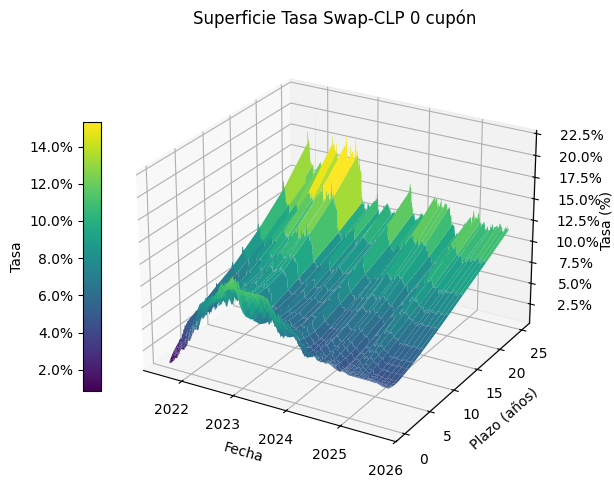

In [17]:
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

def tenor_to_months(s: str) -> int:
    m = re.fullmatch(r'(?:(\d+)Y)?(?:(\d+)M)?', str(s).strip().upper())
    y  = int(m.group(1)) if m and m.group(1) else 0
    mo = int(m.group(2)) if m and m.group(2) else 0
    return 12*y + mo

# --- datos ---
df = TASAS_0_CUPON_FILTRADAS.copy()          # filas = fechas (o índice numérico), columnas = tenores
cols_sorted = sorted(df.columns, key=tenor_to_months)
df = df[cols_sorted]

# FECHAS puede ser Serie o DataFrame con una columna de fechas
fechas = pd.to_datetime(FECHAS["Fecha"].squeeze())
dates_num = mdates.date2num(fechas.to_numpy())   # eje X con fechas reales

# si tus tasas están en decimales (0.05), pásalas a % para el gráfico
if df.to_numpy().max() <= 1.0:
    df_plot = df * 100.0
else:
    df_plot = df.copy()   # ya está en %

tenor_years = np.array([tenor_to_months(c)/12 for c in df_plot.columns])

# mallas y Z
X, Y = np.meshgrid(dates_num, tenor_years, indexing="xy")
Z = np.ma.masked_invalid(df_plot.to_numpy().T)   # (tenor x fecha)

# --- plot ---
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap="viridis", linewidth=0, antialiased=True)
# después de crear 'ax' y el 'surf'
ax.view_init(elev=25, azim=35)   # prueba 20–60 hasta que te guste


ax.set_title("Superficie Tasa Swap-CLP 0 cupón")
ax.set_xlabel("Fecha")
ax.set_ylabel("Plazo (años)")
ax.set_zlabel("Tasa")

# 1) Que Matplotlib NO rote automáticamente el label del eje Z
ax.zaxis.set_rotate_label(False)

# 2) Fija el texto y su rotación (en grados)
ax.set_zlabel("Tasa (%)", labelpad=12)   # separa un poco si quieres
ax.zaxis.label.set_rotation(90)          # 90 = vertical, 0 = horizontal

# (opcional) porcentaje en ticks y pequeña separación
ax.zaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax.tick_params(axis='z', pad=8)
# formateo del eje X como fechas
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# eje Z en porcentaje con símbolo %
ax.zaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))   # porque Z está en 0–100
ax.tick_params(axis='z', pad=12)   # separa los ticks del colorbar

# colorbar al LADO IZQUIERDO
cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=15, pad=0.01, location='left')
cbar.set_label("Tasa")
cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

# opcional: cambia ángulo de cámara si lo necesitas
ax.view_init(elev=25, azim=-60)
plt.tight_layout()


# antes o en lugar de plt.show()
plt.savefig("superficie_swap.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


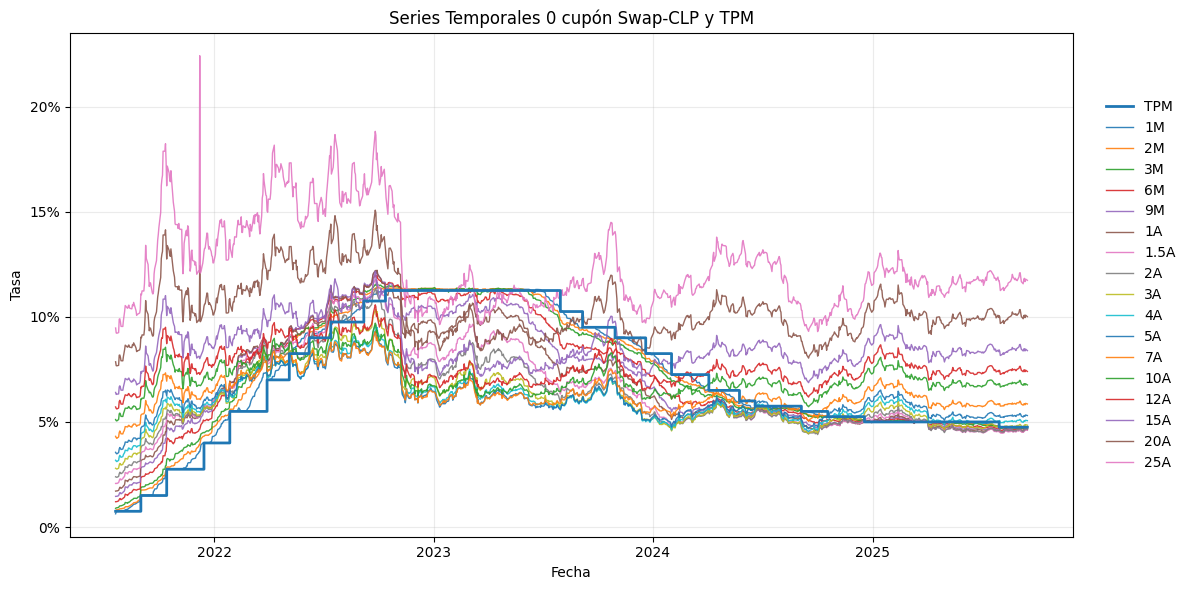

In [18]:

# --- helpers ---
def tenor_to_months(s: str) -> int:
    m = re.fullmatch(r'(?:(\d+)Y)?(?:(\d+)M)?', str(s).strip().upper())
    y  = int(m.group(1)) if m and m.group(1) else 0
    mo = int(m.group(2)) if m and m.group(2) else 0
    return 12*y + mo

def label_tenor_es(s: str) -> str:
    m = tenor_to_months(s)
    if m < 12:
        return f"{m}M"
    y, mo = divmod(m, 12)
    if mo == 0:       return f"{y}A"
    if mo == 6:       return f"{y + 0.5:g}A"   # 1.5a, 2.5a, ...
    return f"{y}A{mo}M"

setA = set(TPM_raw["Fecha"])
setB = set(FECHAS["Fecha"])
x = sorted(setA & setB)

# --- datos ---
df = TASAS_0_CUPON_FILTRADAS.copy()
fechas = pd.to_datetime(FECHAS["Fecha"].squeeze())
df.index = fechas
df = df.sort_index()

# ordena columnas por tenor real
cols_sorted = sorted(df.columns, key=tenor_to_months)
df = df.loc[:, cols_sorted]

# TPM (ajusta el nombre de tu Serie si difiere)
tpm = TPM_raw["TPM"].copy()
tpm.index = pd.to_datetime(tpm.index)
tpm = tpm.reindex(df.index).ffill()  # alinea y rellena escalón

# a porcentaje si viene en decimales
if df.to_numpy().max() <= 1.0: df *= 100.0
if tpm.max() <= 1.0:            tpm *= 100.0

# --- plot ---
fig, ax = plt.subplots(figsize=(12, 6))

def mayuscula(t: str):
    A = t
    for j in len(A):
        if A[j] in "qwertyuiopasdfghjklzxcvbnm":
            A[j] = A[j].upper()


# TPM como escalón grueso
ax.plot(x, TPM_raw[TPM_raw["Fecha"].isin(x)]["TPM"], color="tab:blue", lw=2, drawstyle="steps-post", label="TPM", zorder=5)

# curvas por tenor
for c in df.columns:
    ax.plot(FECHAS["Fecha"], TASAS_0_CUPON_FILTRADAS[c], lw=1.0, alpha=0.9, label=label_tenor_es(c))


# formato ejes
ax.set_title("Series Temporales 0 cupón Swap-CLP y TPM")
ax.set_xlabel("Fecha"); ax.set_ylabel("Tasa")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
ax.xaxis.set_major_locator(mdates.YearLocator())        # un tick por año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(True, alpha=0.25)

# leyenda a la derecha, fuera del gráfico
ax.legend(title=None, ncol=1, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.savefig("seriestemporales0cupon.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


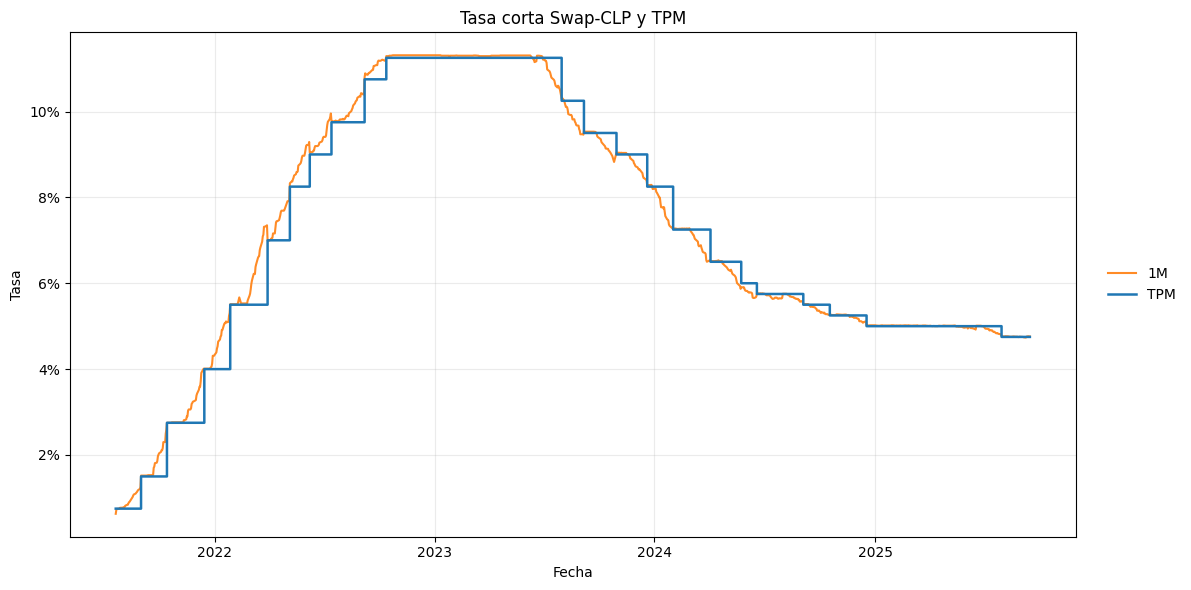

In [19]:
setA = set(TPM_raw["Fecha"])
setB = set(FECHAS["Fecha"])
x = sorted(setA & setB)

# --- datos ---
df = TASAS_0_CUPON_FILTRADAS.copy()
fechas = pd.to_datetime(FECHAS["Fecha"].squeeze())
df.index = fechas
df = df.sort_index()

# ordena columnas por tenor real
cols_sorted = sorted(df.columns, key=tenor_to_months)
df = df.loc[:, cols_sorted]

# TPM (ajusta el nombre de tu Serie si difiere)
tpm = TPM_raw["TPM"].copy()
tpm.index = pd.to_datetime(tpm.index)
tpm = tpm.reindex(df.index).ffill()  # alinea y rellena escalón

# a porcentaje si viene en decimales
if df.to_numpy().max() <= 1.0: df *= 100.0
if tpm.max() <= 1.0:            tpm *= 100.0

# --- plot ---
fig, ax = plt.subplots(figsize=(12, 6))

def mayuscula(t: str):
    A = t
    for j in len(A):
        if A[j] in "qwertyuiopasdfghjklzxcvbnm":
            A[j] = A[j].upper()
# curvas por tenor

ax.plot(FECHAS["Fecha"], TASAS_0_CUPON_FILTRADAS["1M"], lw=1.5, alpha=0.9, label="1M",color="tab:orange")


# TPM como escalón grueso
ax.plot(x, TPM_raw[TPM_raw["Fecha"].isin(x)]["TPM"], color="tab:blue", lw=1.8, drawstyle="steps-post", label="TPM", zorder=5)

# formato ejes
ax.set_title("Tasa corta Swap-CLP y TPM")
ax.set_xlabel("Fecha"); ax.set_ylabel("Tasa")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
ax.xaxis.set_major_locator(mdates.YearLocator())        # un tick por año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(True, alpha=0.25)

# leyenda a la derecha, fuera del gráfico
ax.legend(title=None, ncol=1, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.savefig("tasacortatpm.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


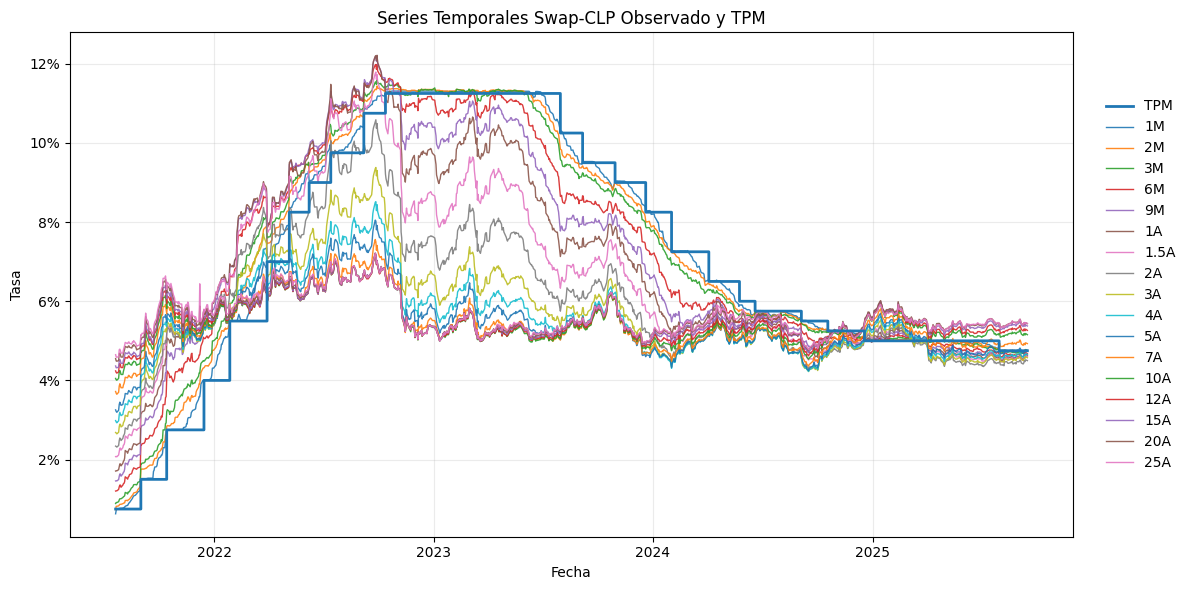

In [21]:
setA = set(TPM_raw["Fecha"])
setB = set(FECHAS["Fecha"])
x = sorted(setA & setB)

# --- datos ---
df = TASAS_0_CUPON_FILTRADAS.copy()
fechas = pd.to_datetime(FECHAS["Fecha"].squeeze())
df.index = fechas
df = df.sort_index()

# ordena columnas por tenor real
cols_sorted = sorted(df.columns, key=tenor_to_months)
df = df.loc[:, cols_sorted]

# TPM (ajusta el nombre de tu Serie si difiere)
tpm = TPM_raw["TPM"].copy()
tpm.index = pd.to_datetime(tpm.index)
tpm = tpm.reindex(df.index).ffill()  # alinea y rellena escalón

# a porcentaje si viene en decimales
if df.to_numpy().max() <= 1.0: df *= 100.0
if tpm.max() <= 1.0:            tpm *= 100.0

# --- plot ---
fig, ax = plt.subplots(figsize=(12, 6))


# TPM como escalón grueso
ax.plot(x, TPM_raw[TPM_raw["Fecha"].isin(x)]["TPM"], color="tab:blue", lw=2, drawstyle="steps-post", label="TPM", zorder=5)

# curvas por tenor
for c in df.columns:
    ax.plot(FECHAS["Fecha"], DFFF[Tenor[c]], lw=1.0, alpha=0.9, label=label_tenor_es(c))


# formato ejes
ax.set_title("Series Temporales Swap-CLP Observado y TPM")
ax.set_xlabel("Fecha"); ax.set_ylabel("Tasa")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
ax.xaxis.set_major_locator(mdates.YearLocator())        # un tick por año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(True, alpha=0.25)

# leyenda a la derecha, fuera del gráfico
ax.legend(title=None, ncol=1, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.savefig("seriestemporalesobservadas.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

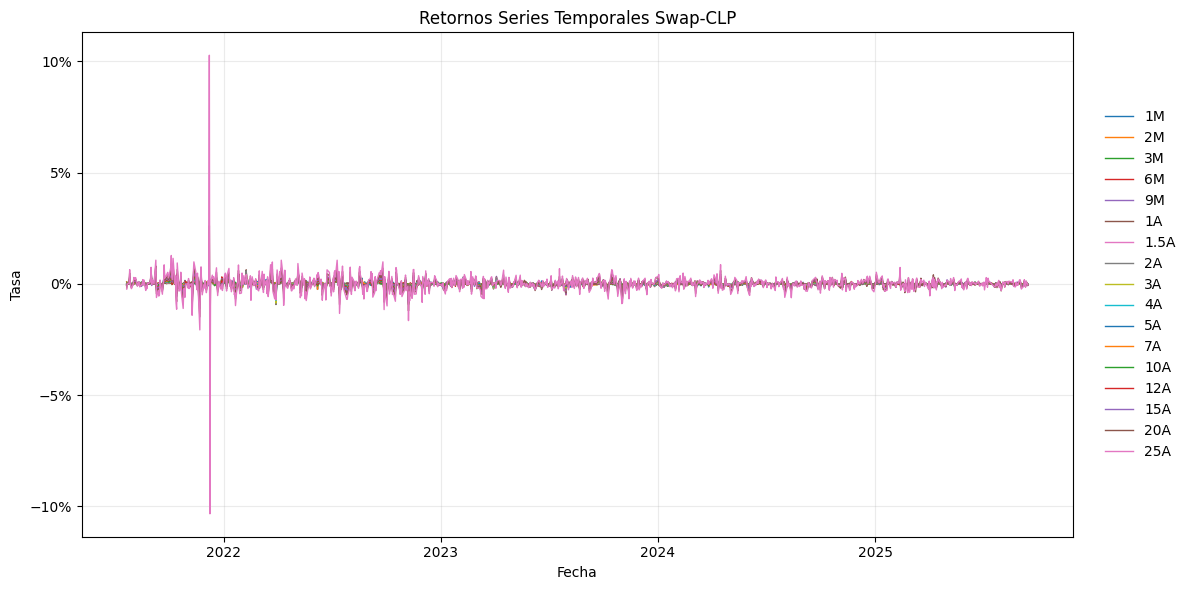

In [25]:
# --- datos ---

dX = TASAS_0_CUPON_FILTRADAS.copy().diff().dropna()
df = dX.copy()
fechas = pd.to_datetime(FECHAS["Fecha"].squeeze())
df
df.index = fechas[1:]
df = df.sort_index()

# ordena columnas por tenor real
cols_sorted = sorted(df.columns, key=tenor_to_months)
df = df.loc[:, cols_sorted]


# a porcentaje si viene en decimales
if df.to_numpy().max() <= 1.0: df *= 100.0

# --- plot ---
fig, ax = plt.subplots(figsize=(12, 6))


# curvas por tenor
for c in df.columns:
    ax.plot(fechas[1:], df[c], lw=1.0, alpha=1, label=label_tenor_es(c))


# formato ejes
ax.set_title("Retornos Series Temporales Swap-CLP")
ax.set_xlabel("Fecha"); ax.set_ylabel("Tasa")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
ax.xaxis.set_major_locator(mdates.YearLocator())        # un tick por año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(True, alpha=0.25)

# leyenda a la derecha, fuera del gráfico
ax.legend(title=None, ncol=1, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.savefig("retornos.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

In [26]:
print(dX.loc[dX["25Y"] == max(dX["25Y"])])
# dX["25Y"][100]
for i in [99, 100, 101]:
    print(FECHAS["Fecha"][i])
for i in [99, 100, 101]:
    print(TASAS_0_CUPON_FILTRADAS.loc[i])

for i in [99, 100, 101]:
    print(FECHAS.loc[i])

      1M   2M   3M   6M   9M   1Y  1Y6M   2Y   3Y        4Y        5Y  \
100  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.012851  0.006391   

           7Y       10Y       12Y       15Y       20Y        25Y  
100  0.007079 -0.011711 -0.085818 -0.111885  2.613235  10.273041  
2021-12-07 00:00:00
2021-12-08 00:00:00
2021-12-09 00:00:00
1M       3.590000
2M       3.915000
3M       4.190000
6M       4.645000
9M       5.025000
1Y       5.245000
1Y6M     5.250000
2Y       5.266631
3Y       5.313301
4Y       5.476529
5Y       5.660868
7Y       6.091224
10Y      6.751277
12Y      7.341489
15Y      8.120460
20Y      9.811650
25Y     12.142747
Name: 99, dtype: float64
1M       3.590000
2M       3.915000
3M       4.190000
6M       4.645000
9M       5.025000
1Y       5.245000
1Y6M     5.250000
2Y       5.266631
3Y       5.313301
4Y       5.489380
5Y       5.667259
7Y       6.098303
10Y      6.739566
12Y      7.255671
15Y      8.008575
20Y     12.424884
25Y     22.415787
Name: 100, dtype: floa

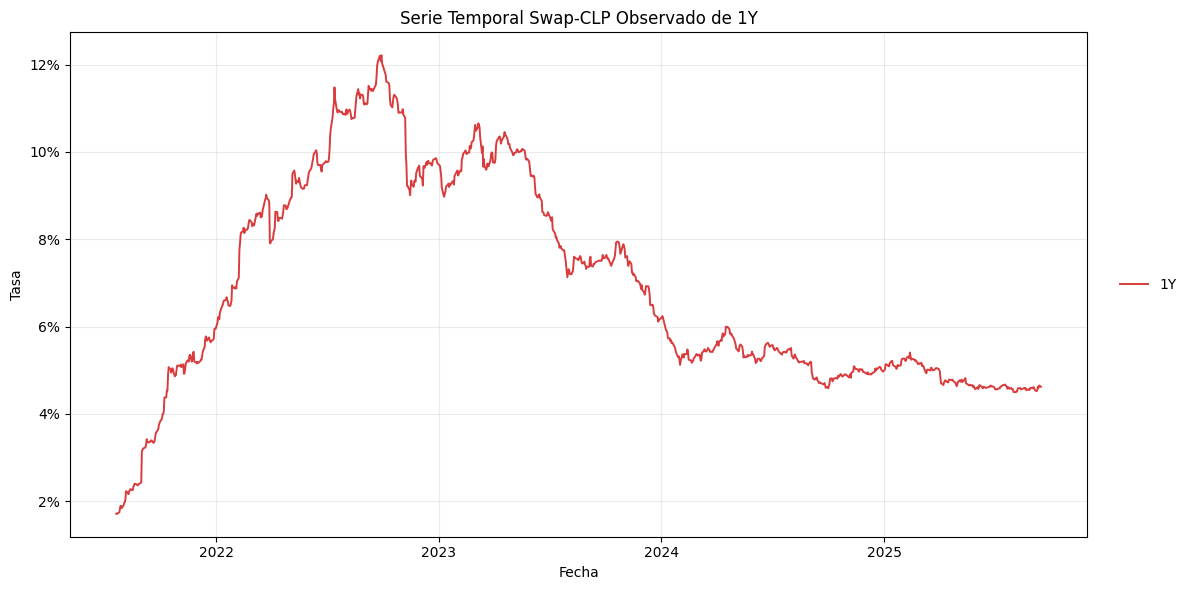

In [127]:

setA = set(TPM_raw["Fecha"])
setB = set(FECHAS["Fecha"])
x = sorted(setA & setB)

# ordena columnas por tenor real
cols_sorted = sorted(df.columns, key=tenor_to_months)
df = df.loc[:, cols_sorted]
# a porcentaje si viene en decimales
if df.to_numpy().max() <= 1.0: df *= 100.0
if tpm.max() <= 1.0:            tpm *= 100.0

# --- plot ---
fig, ax = plt.subplots(figsize=(12, 6))


# curvas por tenor

ax.plot(FECHAS["Fecha"], DFFF[Tenor["1Y"]], lw=1.4, alpha=0.9, label= "1Y", color="tab:red")

# formato ejes
ax.set_title("Serie Temporal Swap-CLP Observado de 1Y")
ax.set_xlabel("Fecha"); ax.set_ylabel("Tasa")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
ax.xaxis.set_major_locator(mdates.YearLocator())        # un tick por año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(True, alpha=0.25)

# leyenda a la derecha, fuera del gráfico
ax.legend(title=None, ncol=1, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.savefig("ejemplo.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


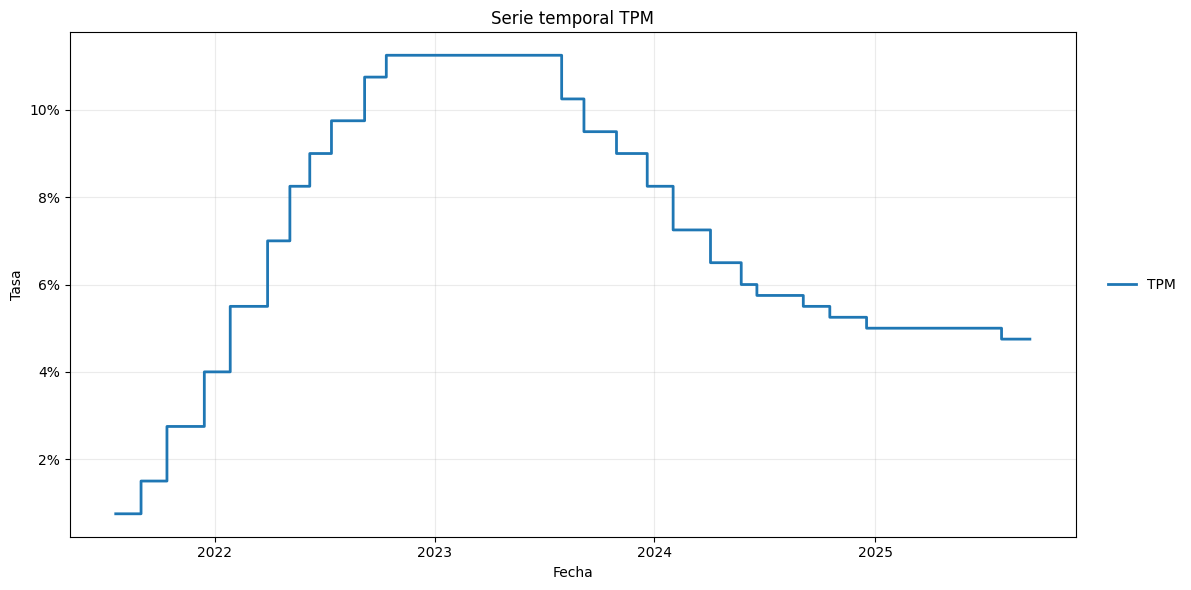

In [131]:
setA = set(TPM_raw["Fecha"])
setB = set(FECHAS["Fecha"])
x = sorted(setA & setB)

# TPM (ajusta el nombre de tu Serie si difiere)
tpm = TPM_raw["TPM"].copy()
tpm.index = pd.to_datetime(tpm.index)
tpm = tpm.reindex(df.index).ffill()  # alinea y rellena escalón

if tpm.max() <= 1.0: tpm *= 100.0

# --- plot ---
fig, ax = plt.subplots(figsize=(12, 6))


# TPM como escalón grueso
ax.plot(x, TPM_raw[TPM_raw["Fecha"].isin(x)]["TPM"], color="tab:blue", lw=2, drawstyle="steps-post", label="TPM", zorder=5)


# formato ejes
ax.set_title("Serie temporal TPM")
ax.set_xlabel("Fecha"); ax.set_ylabel("Tasa")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
ax.xaxis.set_major_locator(mdates.YearLocator())        # un tick por año
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(True, alpha=0.25)

# leyenda a la derecha, fuera del gráfico
ax.legend(title=None, ncol=1, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.savefig("TPM.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

In [30]:
TASAS_0_CUPON_FILTRADAS

,1M,2M,3M,6M,9M,1Y,1Y6M,2Y,3Y,4Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y
0,0.630,0.735,0.890,1.205,1.460,1.710,2.075,2.391460,2.795301,3.177638,3.555096,4.314135,5.112941,5.711661,6.403304,7.860283,9.466385
1,0.720,0.820,0.915,1.210,1.465,1.720,2.080,2.380756,2.778761,3.137021,3.506458,4.253084,5.060007,5.641446,6.308484,7.677285,9.229735
2,0.745,0.820,0.915,1.210,1.460,1.715,2.070,2.365007,2.756974,3.114402,3.482806,4.219634,5.047786,5.616674,6.319192,7.669325,9.218175
3,0.745,0.830,0.935,1.245,1.495,1.745,2.115,2.406638,2.800038,3.170938,3.541936,4.285301,5.115655,5.660566,6.331965,7.690522,9.249887
4,0.755,0.850,0.980,1.310,1.575,1.820,2.205,2.532350,2.952266,3.341168,3.713810,4.491260,5.384406,5.971542,6.665941,8.172764,9.886394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,4.740,4.725,4.695,4.625,4.575,4.550,4.535,4.588261,4.803867,5.034427,5.288922,5.852851,6.808229,7.464542,8.465189,10.051662,11.755636
1038,4.760,4.760,4.745,4.695,4.645,4.620,4.605,4.652056,4.853244,5.061272,5.304032,5.862824,6.821400,7.480023,8.484541,10.078387,11.828406
1039,4.760,4.755,4.750,4.685,4.635,4.600,4.585,4.625083,4.825049,5.031707,5.266096,5.812707,6.751518,7.388868,8.376089,9.960488,11.673920
1040,4.765,4.765,4.780,4.710,4.680,4.650,4.630,4.673275,4.869670,5.078623,5.329214,5.882981,6.815283,7.461496,8.464087,10.078228,11.791128


In [60]:
DF_DIFERENCIAS = TASAS_0_CUPON_FILTRADAS.diff().dropna().reset_index(drop=True)

In [61]:
DF_DIFERENCIAS

,1,2,3,6,9,12,18,24,36,48,60,84,120,144,180,240,300
0,0.090,0.085,0.025,0.005,0.005,0.010,0.005,-0.010705,-0.016539,-0.040616,-0.048638,-0.061050,-0.052933,-0.070216,-0.094821,-0.182998,-0.236649
1,0.025,0.000,0.000,0.000,-0.005,-0.005,-0.010,-0.015749,-0.021787,-0.022620,-0.023652,-0.033450,-0.012222,-0.024772,0.010709,-0.007960,-0.011561
2,0.000,0.010,0.020,0.035,0.035,0.030,0.045,0.041632,0.043064,0.056536,0.059131,0.065667,0.067869,0.043892,0.012773,0.021197,0.031712
3,0.010,0.020,0.045,0.065,0.080,0.075,0.090,0.125712,0.152228,0.170230,0.171874,0.205959,0.268751,0.310977,0.333976,0.482242,0.636507
4,0.015,0.020,0.030,0.045,0.060,0.070,0.080,0.073004,0.070132,0.073212,0.070444,0.078855,0.037958,0.054898,0.051525,0.009892,0.019691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,0.005,0.000,0.015,0.025,0.030,0.030,0.030,0.026568,0.033762,0.054353,0.056996,0.055530,0.066683,0.075537,0.090892,0.144238,0.185130
1037,0.020,0.035,0.050,0.070,0.070,0.070,0.070,0.063795,0.049377,0.026845,0.015110,0.009973,0.013172,0.015482,0.019352,0.026724,0.072770
1038,0.000,-0.005,0.005,-0.010,-0.010,-0.020,-0.020,-0.026973,-0.028195,-0.029565,-0.037935,-0.050117,-0.069883,-0.091155,-0.108452,-0.117898,-0.154486
1039,0.005,0.010,0.030,0.025,0.045,0.050,0.045,0.048192,0.044621,0.046916,0.063117,0.070274,0.063765,0.072628,0.087997,0.117739,0.117208


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

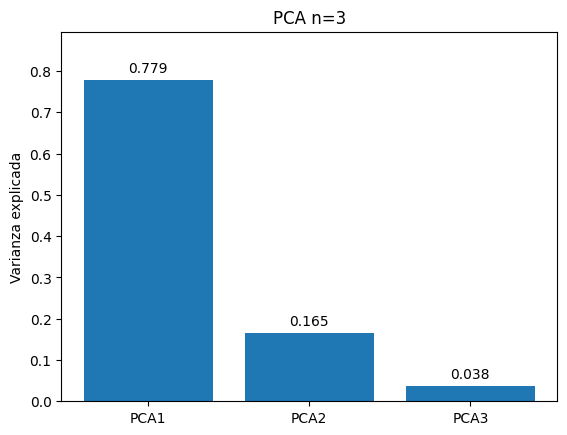

In [62]:
ss = StandardScaler(with_std=False)
X = DF_DIFERENCIAS.copy()
X_cols = DF_DIFERENCIAS.columns.tolist()
X[X_cols] = ss.fit_transform(DF_DIFERENCIAS[X_cols])
n = 3
pca_raw = PCA(n_components = n, random_state = 42)
scores = pca_raw.fit_transform(X[X_cols])

# sns.barplot(x=[f"PCA{i+1}" for i in range(n)], y=pca_raw.explained_variance_ratio_)
labels = ["PCA1", "PCA2", "PCA3"]
vals   = pca_raw.explained_variance_ratio_  # por ejemplo, varianza explicada
fig, ax = plt.subplots()
bars = ax.bar(labels, vals)

ax.set_title("PCA n=3")
# espacio arriba para que quepan los números
ax.set_ylim(0, max(vals)*1.15)

# Opción A: en decimales
ax.bar_label(bars, fmt="%.3f", padding=3)

# Si prefieres en porcentaje, comenta la línea anterior y usa esta:
# ax.bar_label(bars, labels=[f"{v*100:.1f}%" for v in vals], padding=3)

ax.set_ylabel("Varianza explicada")

plt.savefig("PCA.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.tight_layout